In [393]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import Base: show

In [394]:
function vmp(n, iters, data)
    model = Model(DefaultMessageGate())
    
    mean_mean = add!(model, datavar(:mean_mean, Float64))
    mean_prec = add!(model, datavar(:mean_prec, Float64))
    
    prec_a = add!(model, datavar(:precision, Float64))
    prec_b = add!(model, datavar(:precision, Float64))
            
    meanv = add!(model, randomvar(:mean))
    precv = add!(model, randomvar(:prec))
            
    mean_gaussian_node = add!(model, make_node(NormalMeanPrecision{Float64}, mean_mean, mean_prec, meanv))
    prec_gamma_node    = add!(model, make_node(GammaAB{Float64}, prec_a, prec_b, precv))

    y = add!(model, datavar(:y, Float64))
    
    gmpnode = add!(model, make_node(NormalMeanPrecision{Float64}, meanv, precv, y, factorisation = ( (1,) , (2,) , (3,) )))

    activate!(model)

    currentmeanv = Ref(NormalMeanPrecision(0.0, 0.00001))
    currentprecv = Ref(GammaAB(0.1, 0.1))
    
    setmarginal!(gmpnode, :mean, currentmeanv[])
    setmarginal!(gmpnode, :precision, currentprecv[])

    subscribe!(getmarginal(meanv), (d) -> currentmeanv[] = getdata(d))
    subscribe!(getmarginal(precv), (d) -> currentprecv[] = getdata(d))

    fe_scheduler = PendingScheduler()

    fe = Vector{Float64}()
    ma = Vector{Float64}(undef, n)
    pa = Vector{Float64}(undef, n)

    subscription = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d)) 
    
    for i in 1:n
        tmp1 = currentmeanv[]
        tmp2 = currentprecv[]
        
        warmup = 1
        for _ in 1:warmup
            update!(y, data[i])
            update!(mean_mean, tmp1.mean)
            update!(mean_prec, tmp1.precision)
            update!(prec_a, tmp2.a)
            update!(prec_b, tmp2.b)
            # update!(y, data[i])
        end

        for j in 1:iters
            update!(y, data[i])
            update!(mean_mean, tmp1.mean)
            update!(mean_prec, tmp1.precision)
            update!(prec_a, tmp2.a)
            update!(prec_b, tmp2.b)
            # update!(y, data[i])
#             update!(mean_mean, tmp1.mean)
#             update!(mean_prec, tmp1.precision)
#             update!(prec_a, tmp2.a)
#             update!(prec_b, tmp2.b)
            release!(fe_scheduler)
        end
        
        ma[i] = mean(currentmeanv[])
        pa[i] = mean(currentprecv[])
    end
    
    unsubscribe!(subscription)
    
    return fe, ma, pa
end

vmp (generic function with 1 method)

In [395]:
import ReactiveMP: score

function ReactiveMP.score(::DifferentialEntropy, factorised::Marginal{ <: Tuple })
   return mapreduce(d -> score(DifferentialEntropy(), as_marginal(d)), +, getdata(factorised), init = 0.0) 
end

function ReactiveMP.score(::DifferentialEntropy, factorised::Marginal{Float64})
    return 0.0
end

In [396]:
realprecision = 0.01999
realmean = -200.0
n = 2000
iters = 5

data = rand(Normal(realmean, sqrt(1.0 / realprecision)), (n, ));

In [397]:
@time fe, ma, pa = vmp(n, iters, data);

  2.601668 seconds (6.51 M allocations: 326.220 MiB, 3.39% gc time)


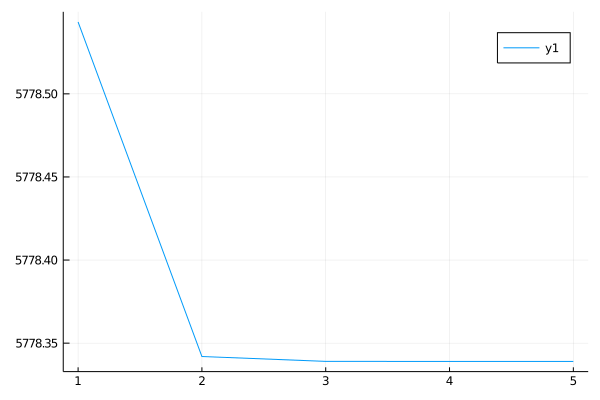

In [398]:
fevalues = reshape(fe, (iters, n))
plot(vec(sum(fevalues, dims = 2)))

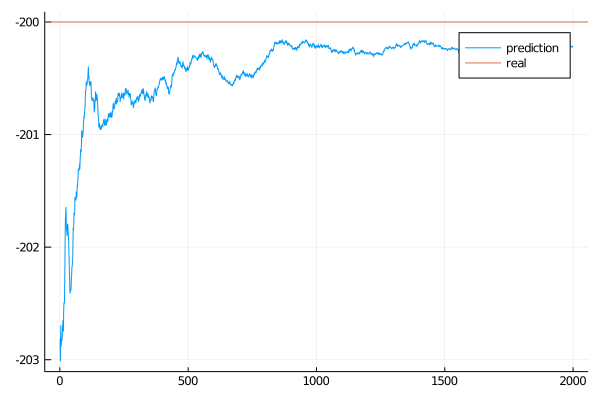

In [399]:
plot(ma[2:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

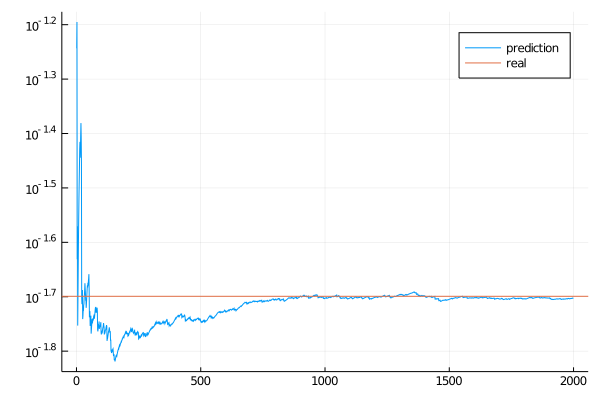

In [400]:
plot(pa[2:end], label = :prediction, yscale = :log10)
plot!([ realprecision ], seriestype=:hline, label = :real)